In [1]:
import cv2
import logging
import warnings
import os
from pathlib import Path
from typing import Tuple, Dict, Union
import io
import base64

import numpy as np
import torch
from PIL import Image
from facenet_pytorch import MTCNN, InceptionResnetV1
import torchvision.transforms as transforms
from IPython.display import display, HTML

warnings.filterwarnings("ignore")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
mtcnn = MTCNN(image_size=160, margin=40, min_face_size=20,
              thresholds=[0.6, 0.7, 0.7], factor=0.709,
              post_process=True, device=device, keep_all=False)
resnet = InceptionResnetV1(pretrained='vggface2').eval().to(device)

transform = transforms.Compose([
    transforms.Resize((160, 160)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

def align_face_with_landmarks(image: Image.Image, landmarks: dict,
                               desired_left_eye=(0.35, 0.35), output_size=(160, 160)):
    left_eye = np.array(landmarks['left_eye'])
    right_eye = np.array(landmarks['right_eye'])

    eye_center = (left_eye + right_eye) / 2
    delta_x = right_eye[0] - left_eye[0]
    delta_y = right_eye[1] - left_eye[1]
    angle = np.degrees(np.arctan2(delta_y, delta_x))

    dist = np.sqrt((delta_x ** 2) + (delta_y ** 2))
    desired_dist = (1.0 - 2 * desired_left_eye[0]) * output_size[0]
    scale = desired_dist / dist

    M = cv2.getRotationMatrix2D(tuple(eye_center), angle, scale)
    tX = output_size[0] * 0.5
    tY = output_size[1] * desired_left_eye[1]
    M[0, 2] += (tX - eye_center[0])
    M[1, 2] += (tY - eye_center[1])

    aligned_img = cv2.warpAffine(np.array(image), M, output_size, flags=cv2.INTER_CUBIC)
    return aligned_img

def load_face(image_path: Union[str, Path]) -> Tuple[np.ndarray, float]:
    image_path = Path(image_path)
    if not image_path.is_file():
        raise FileNotFoundError(f"Image not found: {image_path}")
    img = Image.open(image_path).convert('RGB')

    boxes, probs, landmarks = mtcnn.detect(img, landmarks=True)
    if boxes is None or probs is None or landmarks is None or probs[0] < 0.90:
        raise RuntimeError(f"Face not detected confidently in {image_path}")

    aligned = align_face_with_landmarks(img, {
        'left_eye': landmarks[0][0],
        'right_eye': landmarks[0][1]
    })

    prob_value = probs[0].item() if isinstance(probs[0], torch.Tensor) else probs[0]
    return aligned, prob_value

def get_embedding(face_array: np.ndarray) -> np.ndarray:
    img = Image.fromarray(face_array)
    img_tensor = transform(img).unsqueeze(0).to(device)
    with torch.no_grad():
        embedding = resnet(img_tensor).cpu().numpy()[0]
    return embedding / np.linalg.norm(embedding)

def show_visual_comparison(face1: np.ndarray, face2: np.ndarray, title1="Face 1", title2="Face 2"):
    face1_resized = cv2.resize(face1, (160, 160))
    face2_resized = cv2.resize(face2, (160, 160))
    diff = cv2.absdiff(face1_resized, face2_resized)

    comparison = np.hstack((face1_resized, face2_resized, diff))
    comparison_with_text = comparison.copy()

    cv2.putText(comparison_with_text, title1, (10, 20),
                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)
    cv2.putText(comparison_with_text, title2, (170, 20),
                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)
    cv2.putText(comparison_with_text, "Difference", (330, 20),
                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)

    comparison_rgb = cv2.cvtColor(comparison_with_text, cv2.COLOR_BGR2RGB)
    pil_img = Image.fromarray(comparison_rgb)
    buffer = io.BytesIO()
    pil_img.save(buffer, format='JPEG')
    buffer.seek(0)
    img_str = base64.b64encode(buffer.getvalue()).decode('ascii')
    display(HTML(f'<img src="data:image/jpeg;base64,{img_str}" />'))

def compute_similarity(img_path1: Union[str, Path], img_path2: Union[str, Path], base_threshold: float = 0.8) -> Dict[str, Union[float, bool]]:
    face1, prob1 = load_face(img_path1)
    face2, prob2 = load_face(img_path2)

    emb1 = get_embedding(face1)
    emb2 = get_embedding(face2)

    cosine_sim = np.dot(emb1, emb2)
    similarity_percent = round(cosine_sim * 100, 2)
    verified = similarity_percent >= (base_threshold * 100)
    confidence_level = round((prob1 + prob2) / 2 * 100, 2)

    # Show visual comparison
    show_visual_comparison(face1, face2)

    return {
        "similarity_score_percent": similarity_percent,
        "verified": verified,
        "cosine_similarity": round(cosine_sim, 4),
        "confidence": confidence_level,
        "threshold_used": round(base_threshold * 100, 2)
    }

c:\Users\khoji\anaconda3\envs\torch-gpu\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm



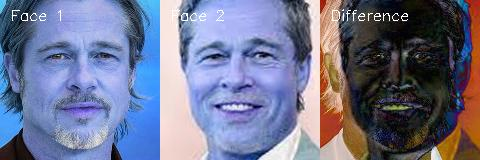

Similarity Score (%): 83.62
Are they the same person? True


In [2]:
# Manual Test (for notebook or script use)
desktop_path = os.path.join(os.path.expanduser("~"), "Desktop")
img1 = os.path.join(desktop_path, "gettyimages-1165177751-2000-d105ca4fa12c49efae54bba6cac13822.jpg")
img2 = os.path.join(desktop_path, "images.jpg")

result = compute_similarity(img1, img2, base_threshold=0.7)
# base_threshold=0.7 means:
#     If cosine_sim ≥ 0.7, we assume same person.
#     If < 0.7, we assume different people.

print("Similarity Score (%):", result['similarity_score_percent'])
print("Are they the same person?", result['verified'])


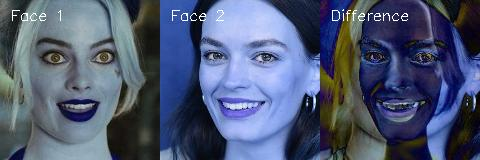

Similarity Score (%): 34.18
Are they the same person? False


In [4]:
desktop_path = os.path.join(os.path.expanduser("~"), "Desktop")
img1 = os.path.join(desktop_path, "Margot_Robbie_Mug.jpg")
img2 = os.path.join(desktop_path, "0ed87b58-b9a2-4ed4-bc5e-69ff20f3c313_f750x750.jpg")

result = compute_similarity(img1, img2, base_threshold=0.7)
print("Similarity Score (%):", result['similarity_score_percent'])
print("Are they the same person?", result['verified'])


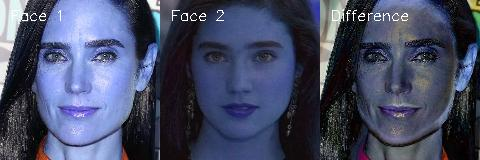

Similarity Score (%): 70.01
Are they the same person? True


In [5]:
desktop_path = os.path.join(os.path.expanduser("~"), "Desktop")
img1 = os.path.join(desktop_path, "MV5BNGMwYmU3MTAtYjcyOC00NGMzLTgzYzItMTc4YzQwNzNhYjRmXkEyXkFqcGc@._V1_FMjpg_UX1000_.jpg")
img2 = os.path.join(desktop_path, "i-dont-get-the-appeal-over-jennifer-connelly-i-know-im-v0-kngx9x6e79gc1.jpg")

result = compute_similarity(img1, img2, base_threshold=0.7)
# Since we're experiencing false negatives with same person, reducing the threshold to 0.7 is a reasonable fix without changing the model.

print("Similarity Score (%):", result['similarity_score_percent'])
print("Are they the same person?", result['verified'])